In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "4,5,6,7"
import torch
from tqdm import tqdm
import plotly.express as px

torch.set_grad_enabled(False);

# %%
from transformer_lens import HookedTransformer
from sae_lens import SAE

# Choose a layer you want to focus on
device= "cuda:0"
model = HookedTransformer.from_pretrained("gpt2-small").to('cuda')

# Initialize SAE
layer = 10
sae, cfg_dict, _ = SAE.from_pretrained(
    release="gpt2-small-res-jb",
    sae_id=f"blocks.{layer}.hook_resid_pre",
    device= "cuda:0"
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
blocks.10.hook_resid_pre


## Necessary Functions

In [3]:
def get_top_k_active_directions(sae: SAE, activation: torch.Tensor, k: int):
    latent = sae.encode(activation)  # [16, n_features]
    top_k_values, top_k_indices = torch.topk(latent.abs(), k, dim=-1)  # Both: [16, 5]
    # Gather top k directions for each item in the batch
    top_k_directions = sae.W_enc[:, top_k_indices.flatten()].view(sae.W_enc.shape[0], k, -1)  # [768, 5, 16]
    return top_k_directions, top_k_values

In [4]:
def compute_subsequent_outputs_logits_only(model: torch.nn.Module, activation: torch.Tensor, layer_index: int) -> torch.Tensor:
    # Ensure activation requires gradients
    with torch.enable_grad():
        if not activation.requires_grad:
            activation.requires_grad_(True)
        if activation.ndim == 2:
            activation = activation.unsqueeze(1)       
        current_activation = activation
        for block in model.blocks[layer_index+1:]:
            current_activation = block(current_activation)
            
        current_activation = model.ln_final(current_activation)
        logits = model.unembed(current_activation)
    return logits

In [5]:
from typing import Union
def compute_subsequent_outputs_logits_only(
    model: Union[HookedTransformer, torch.nn.Module],
    activation: torch.Tensor,
    layer_index: int
) -> torch.Tensor:
    """
    Compute logits from an intermediate activation for various model architectures.

    Args:
    - model: The transformer model (HookedTransformer or nn.Module)
    - activation: Intermediate activation tensor
    - layer_index: Index of the current layer

    Returns:
    - logits: Output logits tensor
    """
    with torch.enable_grad():
        if not activation.requires_grad:
            activation.requires_grad_(True)
        
        # Ensure activation has the correct shape
        if activation.ndim == 2:
            activation = activation.unsqueeze(1)
        
        current_activation = activation

        # Process through remaining transformer blocks
        try:
            remaining_blocks = model.blocks[layer_index+1:]
        except AttributeError:
            # For models that might use a different attribute name
            remaining_blocks = getattr(model, 'layers', getattr(model, 'transformer', model))[layer_index+1:]

        for block in remaining_blocks:
            current_activation = block(current_activation)
        
        # Apply final layer norm if it exists
        if hasattr(model, 'ln_final'):
            current_activation = model.ln_final(current_activation)
        elif hasattr(model, 'norm'):
            current_activation = model.norm(current_activation)
        
        # Compute logits
        if hasattr(model, 'unembed'):
            logits = model.unembed(current_activation)
        elif hasattr(model, 'lm_head'):
            logits = model.lm_head(current_activation)
        else:
            raise AttributeError("Model doesn't have a recognized output layer (unembed or lm_head)")

    return logits

In [6]:
import torch
from transformer_lens import HookedTransformer
from typing import Tuple
from torch import Tensor

def integrated_gradients(
    model: HookedTransformer,
    input_ids: Tensor,
    target_layer: str,
    n_steps: int = 50,
    largest_logit: bool = False,
) -> Tuple[Tensor, Tensor]:
    """
    Compute Integrated Gradients for a specific layer in the model.

    Args:
    - model: HookedTransformer model
    - input_ids: Input token ids (shape: [batch_size, seq_len])
    - target_layer: Name of the target layer (e.g., 'blocks.0.hook_resid_pre')
    - n_steps: Number of steps for the integration approximation

    Returns:
    - Tuple of (activations, attributions) for the target layer
    """
    device = input_ids.device
    layer_index = int(target_layer.split('.')[1])

    # Get baseline and input activations
    with torch.no_grad():
        _, cache = model.run_with_cache(input_ids)
        input_activation = cache[target_layer]
    
    baseline_activation = torch.zeros_like(input_activation)
    delta = (input_activation - baseline_activation) / n_steps
    integrated_gradients = torch.zeros_like(input_activation)

    for i in range(n_steps + 1):
        with torch.enable_grad():
            with torch.autograd.set_detect_anomaly(True):
                interpolated_activation = baseline_activation + i * delta
                interpolated_activation.requires_grad_(True)
                logits = compute_subsequent_outputs_logits_only(model, interpolated_activation, layer_index)

                if largest_logit:
                    last_token_logits = logits[0, -1]
                    max_logit_value, max_logit_index = torch.max(last_token_logits, dim=-1)
                    
                    # Compute gradient only for the highest logit
                    max_logit_value.backward(retain_graph=True)
                    gradient = interpolated_activation.grad

                    integrated_gradients += gradient / n_steps
                    interpolated_activation.grad = None  
                else:
                    loss = logits[0, -1, input_ids[0, -1]] 
                    loss.backward(create_graph=False)
                    gradient = interpolated_activation.grad

                    integrated_gradients += gradient / n_steps

                if i == 49:
                    probs = torch.nn.functional.softmax(logits[0, -1], dim=-1)
                    _, predicted_token_id = torch.max(probs, dim=-1)
                    predicted_token = model.tokenizer.decode([predicted_token_id.item()])
                    print(f"predited_token: {predicted_token}")
        attributions = integrated_gradients * (input_activation - baseline_activation)
    return input_activation, attributions

In [7]:
import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE
from typing import Tuple, List
from torch import Tensor

def compute_r_score(
        model: HookedTransformer,
        sae: SAE,
        input_ids: Tensor,
        target_layer: str,
        k: int = 5,
        n_steps: int = 50,
        largest_logit: bool = False
    ) -> Tuple[float, Tensor, Tensor, Tensor]:
    """
    input ids: [batch, pos]
    Batch has to be 1. 
    """

    # Compute Integrated Gradients
    activations, ig_attributions = integrated_gradients(model, input_ids, target_layer, n_steps, largest_logit)
    ig_attributions = ig_attributions.squeeze()

    r_scores, sae_directions = compute_r_score_helper(sae,  activations, ig_attributions, k)
    return r_scores, ig_attributions, sae_directions, activations

def compute_r_score_helper(
    sae: SAE,
    activation: torch.Tensor,
    attribution: torch.Tensor,
    k: int = 5
) -> torch.Tensor:
    """
    Compute the R-score for multiple sets of vectors and attributions.
    
    Args:
    activation: Tensor of shape [pos, vector_dim]
    attribution: Tensor of shape [pos, vector_dim]
    k: int
    (where pos is the dimension of the number of tokens)

    Returns:
    r_scores: Tensor of shape [pos]
    """
    epsilon: float = 1e-4
    sae_directions, top_k_values = get_top_k_active_directions(sae, activation, k)
    sae_directions = sae_directions.permute(2, 1, 0)

    # Compute the projection matrix
    V = sae_directions.transpose(1, 2)  # [batch_size, vector_dim, num_vectors]
    VTV = torch.bmm(V.transpose(1, 2), V)  # [batch_size, num_vectors, num_vectors]
    VTV_inv = torch.inverse(VTV + epsilon * torch.eye(VTV.size(1), device=VTV.device).unsqueeze(0))
    P = torch.bmm(torch.bmm(V, VTV_inv), V.transpose(1, 2))  # [batch_size, vector_dim, vector_dim]
    
    # Compute the projection of attribution onto the span of directions
    u = attribution.unsqueeze(-1)  # [batch_size, vector_dim, 1]
    proj_u = torch.bmm(P, u)  # [batch_size, vector_dim, 1]
    
    
    # Compute the R-score
    r_scores = torch.sqrt(
        (torch.bmm(u.transpose(1, 2), proj_u).squeeze(-1) + epsilon) /
        (torch.sum(u**2, dim=1) + epsilon)
    ).squeeze(-1)
    print(f"r_scores {r_scores}")
    return r_scores, sae_directions

## Test Arbitrary Sentences

In [10]:
import torch
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def convert_input_ids_to_char_tokens(model, input_ids):
    tokenizer = model.tokenizer
    
    # Ensure input_ids is a flat list
    if isinstance(input_ids, torch.Tensor):
        input_ids = input_ids.tolist()
    if isinstance(input_ids[0], list):
        input_ids = [item for sublist in input_ids for item in sublist]
    
    # Convert ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Convert tokens to characters
    char_tokens = []
    for token in tokens:
        if token.startswith('Ġ'):  # Remove the 'Ġ' prefix for space
            char_tokens.append(' ')
            char_tokens.append(token[1:])
        elif token.startswith('##'):  # Remove '##' for subwords
            char_tokens.append(token[2:])
        else:
            char_tokens.append(token)
    return char_tokens

def print_r_score_details(model, sae, input_ids, r_scores, activation):
    print()
    tokens = convert_input_ids_to_char_tokens(model, input_ids)
    color_code(tokens, r_scores)
    last_token_pos = (input_ids != model.tokenizer.pad_token_id).sum() - 1
    print(f"Last token R score (updated with attention): {r_scores[last_token_pos].item():.4f}")  
    print(f"Average R score over all tokens: {r_scores.mean().item():.4f}")  
    
    # Print top 5 SAE directions
    activation = activation.squeeze()[last_token_pos]
    sae_activations = sae.encode(activation.squeeze().unsqueeze(0))
    top_sae_indices = torch.topk(sae_activations.abs().squeeze(), 5).indices
    print("\nTop 5 SAE activations for last token:")
    for idx in top_sae_indices:
        #attributions = F.cosine_similarity(get_top_k_active_directions(sae, activation, 5), attributions)
        #weight = sae_activations.squeeze()[idx].item() / sae_activations.squeeze().sum()
        print(f"Feature {idx}: Activation: {sae_activations.squeeze()[idx].item():.4f}")


def color_code(tokens, r_scores):
    # Convert the normalized scores to colors
    cmap = plt.get_cmap('coolwarm')
    r_scores_normalized = (r_scores - r_scores.min()) / (r_scores.max() - r_scores.min())
    colors = []
    score_idx = 0
    for token in tokens:
        if token.strip() == '':  # Skip spaces
            colors.append((1, 1, 1, 1))  # White color for space
        else:
            colors.append(cmap(r_scores_normalized[score_idx].item()))
            score_idx += 1
    # Create HTML string with color-coded tokens
    html_str = ""
    for token, color in zip(tokens, colors):
        color_hex = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
        html_str += f"<span style='color:{color_hex}'>{token} </span>"

    # Display the HTML string
    display(HTML(html_str))

In [11]:
target_layer = f"blocks.{10}.hook_resid_pre"


sentence = "Vin is really sad that his passport is taking a long time to arrive"
input_ids = model.to_tokens(sentence, prepend_bos=True)
k = 5
n_steps = 30
r_scores, ig_attributions, sae_directions, activations = compute_r_score(model, sae, input_ids, target_layer, k, n_steps)
# Find the position of the last non-padding token
last_token_pos = (input_ids != model.tokenizer.pad_token_id).sum() - 1
print_r_score_details(model, sae, input_ids, r_scores, activations)
print("\n" + "-"*50 + "\n")


r_scores tensor([0.1626, 0.0513, 0.0958, 0.0518, 0.1011, 0.0924, 0.1766, 0.0758, 0.1672,
        0.0997, 0.0981, 0.0703, 0.1077, 0.0961, 0.1262, 0.1145],
       device='cuda:0')



Last token R score (updated with attention): 0.1262
Average R score over all tokens: 0.1055

Top 5 SAE activations for last token:
Feature 19083: Activation: 54.2239
Feature 11824: Activation: 12.2834
Feature 20360: Activation: 8.9195
Feature 18518: Activation: 7.2850
Feature 13556: Activation: 6.4242

--------------------------------------------------



## Plot R over many sentences

In [25]:
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
import re
import random


class PromptDataset(Dataset):
    def __init__(self, prompts, tokenizer, max_length=512):
        self.encoded_prompts = tokenizer(prompts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

    def __len__(self):
        return len(self.encoded_prompts['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encoded_prompts.items()}
    
def create_dataset_loader(prompts, model, batch_size=3):
    dataset = PromptDataset(prompts, model.tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# Define a function to get short sentences
def generate_sentences(min_length=15, max_length=25, num_sentences=500):
    dataset = load_dataset('wikitext', 'wikitext-103-raw-v1', split='train', streaming=True)
    sentences = []
    
    for example in dataset:
        for sentence in example['text'].split('.'):
            sentence = sentence.strip()
            words = sentence.split()
            if min_length <= len(words) <= max_length:
                truncate_point = random.randint(1, len(words) - 1)  # Ensure at least one word remains
                truncated_sentence = ' '.join(words[:truncate_point])
                sentences.append(truncated_sentence)
                
                if len(sentences) >= num_sentences:
                    random.shuffle(sentences)
                    return sentences[:num_sentences]

In [ ]:
import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE
from typing import List, Tuple
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def analyze_r_score_distribution(
    model: HookedTransformer,
    sae: SAE,
    dataloader: DataLoader,
    target_layer: str,
    k: int = 5,
    n_steps: int = 30,
    num_samples: int = 100
) -> Tuple[List[float], List[str]]:
    """
    Compute R scores for multiple inputs and analyze the distribution.

    Args:
    - model: HookedTransformer model
    - sae: Sparse Autoencoder model
    - dataloader: DataLoader containing input samples
    - target_layer: Name of the target layer
    - k: Number of top SAE directions to consider
    - n_steps: Number of steps for the IG approximation
    - num_samples: Number of samples to process

    Returns:
    - Tuple of (list of R scores, list of input texts)
    """
    r_scores = []
    r_scores_largest_logits = []
    input_texts = []

    for batch in tqdm(dataloader, total=num_samples):
        input_ids = batch['input_ids'].to(device)
        r_score_tensor, _, _, _ = compute_r_score(model, sae, input_ids, target_layer, 5, 30, False)
        r_score_largest_logit_tensor, _, _, _ = compute_r_score(model, sae, input_ids, target_layer, 5, 30, True)

        for item in [x.item() for x in r_score_tensor.squeeze()]:
            r_scores.append(item)

        for item in [x.item() for x in r_score_largest_logit_tensor.squeeze()]:
            r_scores_largest_logits.append(item)

    return r_scores, r_scores_largest_logits


# Analyze R score distribution
target_layer = f"blocks.{layer}.hook_resid_pre"
prompts = generate_sentences()
dataloader = create_dataset_loader(prompts, model, batch_size=1)
r_scores, r_scores_largest_logits = analyze_r_score_distribution(model, sae, dataloader, target_layer, k=i)

# Plot the distribution of R scores
plt.figure(figsize=(12, 6))
plt.hist(r_scores, alpha=0.5, bins=100, edgecolor='black', color='blue', label='r_scores')
plt.hist(r_scores_largest_logits, alpha=0.5, bins=100, edgecolor='black', color='orange', label='r_scores_largest_logits')
plt.title("Distribution of R Scores")
plt.xlabel("R Score")
plt.ylabel("Frequency")
plt.axvline(np.mean(r_scores), color='r', linestyle='dashed', linewidth=2, label=f'Mean all_logits: {np.mean(r_scores):.4f}')
plt.axvline(np.median(r_scores), color='g', linestyle='dashed', linewidth=2, label=f'Mean largest_logits: {np.median(r_scores_largest_logits):.4f}')
plt.legend()
plt.show()

# Print statistics
print(f"Mean R score: {np.mean(r_scores):.4f}")
print(f"Median R score: {np.median(r_scores):.4f}")
print(f"Min R score: {np.min(r_scores):.4f}")
print(f"Max R score: {np.max(r_scores):.4f}")

# Print inputs with notable R scores
num_examples = 5
sorted_indices = np.argsort(r_scores)

## Sentence Length vs R

In [40]:
import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def calculate_r_score_for_sentence(model, sae, sentence, target_layer, k=5, n_steps=50):
    input_ids = model.to_tokens(sentence, prepend_bos=True)
    print(input_ids.shape)
    r_score, _, _,_ = compute_r_score(model, sae, input_ids, target_layer, k, n_steps)
    return r_score

from datasets import load_dataset
import random

def generate_sentences_of_varying_length(min_length=5, max_length=200, num_sentences=50):
    dataset = load_dataset('wikitext', 'wikitext-103-raw-v1', split='train', streaming=True)
    sentences = []
    
    for example in dataset:
        for sentence in example['text'].split('.'):
            sentence = sentence.strip()
            words = sentence.split()
            if min_length <= len(words) <= max_length:
                sentences.append(sentence)
            if len(sentences) >= num_sentences:
                break
        if len(sentences) >= num_sentences:
            break
    
    # If we don't have enough sentences, repeat the process
    while len(sentences) < num_sentences:
        sentences.extend(sentences[:num_sentences - len(sentences)])
    
    # Shuffle and trim to exactly num_sentences
    random.shuffle(sentences)
    return sentences[:num_sentences]

def plot_r_score_vs_length(model, sae, target_layer):
    sentences = generate_sentences_of_varying_length()
    lengths = []
    r_scores = []

    for sentence in tqdm(sentences, desc="Calculating R scores"):
        length = len(sentence.split())
        r_score = calculate_r_score_for_sentence(model, sae, sentence, target_layer)
        lengths.append(length)
        r_scores.append(r_score)

    plt.figure(figsize=(12, 6))
    plt.scatter(lengths, r_scores, alpha=0.6)
    plt.xlabel('Sentence Length (words)')
    plt.ylabel('R Score')
    plt.title('R Score vs Sentence Length')
    
    # Add trend line
    z = np.polyfit(lengths, r_scores, 1)
    p = np.poly1d(z)
    plt.plot(lengths, p(lengths), "r--", alpha=0.8)

    # Add correlation coefficient
    correlation = np.corrcoef(lengths, r_scores)[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.hist(r_scores, bins=50, edgecolor='black')
    plt.title("Distribution of R Scores")
    plt.xlabel("R Score")
    plt.ylabel("Frequency")
    plt.axvline(np.mean(r_scores), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(r_scores):.4f}')
    plt.axvline(np.median(r_scores), color='g', linestyle='dashed', linewidth=2, label=f'Median: {np.median(r_scores):.4f}')
    plt.legend()
    plt.show()

# Set up the model and SAE
layer = 8
sae, cfg_dict, _ = SAE.from_pretrained(
    release="gpt2-small-res-jb",
    sae_id=f"blocks.{layer}.hook_resid_pre",
    device="cuda:0"
)
target_layer = f"blocks.{layer}.hook_resid_pre"

# Run the test and plot the results
plot_r_score_vs_length(model, sae, target_layer)

Calculating R scores:   0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 13])


Calculating R scores:   0%|          | 0/50 [00:05<?, ?it/s]


KeyboardInterrupt: 

## Average R vs Layer Depth

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


Processing layers:   0%|          | 0/12 [00:00<?, ?it/s]

torch.Size([1, 18])
r_scores tensor([0.3023, 0.0635, 0.0825, 0.1249, 0.1045, 0.1350, 0.0554, 0.0983, 0.1817,
        0.0740, 0.1382, 0.0997, 0.1073, 0.0569, 0.0538, 0.0758, 0.0299, 0.1447],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:   8%|▊         | 1/12 [00:43<08:03, 43.93s/it]

r_scores tensor([0.1228, 0.1434, 0.1118, 0.0979, 0.1452, 0.1185, 0.1310, 0.1482, 0.0590,
        0.1870, 0.1319, 0.0901, 0.0445], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.0615, 0.2094, 0.1437, 0.0708, 0.0836, 0.0284, 0.0329, 0.0720, 0.0702,
        0.1219, 0.0797, 0.1638, 0.0895, 0.0926, 0.1231, 0.1152, 0.0441, 0.0468],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  17%|█▋        | 2/12 [01:24<07:01, 42.14s/it]

r_scores tensor([0.1009, 0.0554, 0.1415, 0.1074, 0.0327, 0.0366, 0.0481, 0.1790, 0.0710,
        0.1271, 0.0181, 0.1040, 0.0919], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.1903, 0.1059, 0.0650, 0.0585, 0.1134, 0.1511, 0.0633, 0.0660, 0.0567,
        0.0775, 0.1671, 0.0990, 0.0785, 0.0878, 0.0736, 0.0923, 0.0514, 0.0914],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  25%|██▌       | 3/12 [02:00<05:54, 39.37s/it]

r_scores tensor([0.0833, 0.0587, 0.1066, 0.0918, 0.0915, 0.0898, 0.0696, 0.1166, 0.0328,
        0.0761, 0.0376, 0.0626, 0.0889], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.3295, 0.0573, 0.0808, 0.0556, 0.0929, 0.1075, 0.1056, 0.0556, 0.1137,
        0.1364, 0.1464, 0.0873, 0.1017, 0.0987, 0.0522, 0.1541, 0.0800, 0.2686],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  33%|███▎      | 4/12 [02:33<04:54, 36.76s/it]

r_scores tensor([0.1534, 0.1202, 0.0764, 0.0946, 0.0349, 0.1631, 0.0771, 0.1138, 0.0994,
        0.1103, 0.2913, 0.1919, 0.0953], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.3561, 0.1164, 0.0434, 0.1117, 0.0847, 0.1527, 0.0973, 0.0808, 0.0593,
        0.1999, 0.0390, 0.0527, 0.1330, 0.0689, 0.1300, 0.0641, 0.1914, 0.1548],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  42%|████▏     | 5/12 [03:01<03:55, 33.68s/it]

r_scores tensor([0.3701, 0.1187, 0.0761, 0.0957, 0.0768, 0.0697, 0.0324, 0.0789, 0.0745,
        0.0373, 0.2171, 0.0731, 0.1672], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.3908, 0.0682, 0.0655, 0.0651, 0.0603, 0.0819, 0.1198, 0.0959, 0.1449,
        0.0949, 0.0612, 0.0598, 0.1038, 0.0568, 0.0769, 0.0657, 0.1404, 0.0563],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  50%|█████     | 6/12 [03:26<03:03, 30.51s/it]

r_scores tensor([0.3184, 0.1018, 0.0659, 0.0759, 0.1052, 0.0930, 0.0989, 0.0513, 0.0921,
        0.0880, 0.0970, 0.1037, 0.0916], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.1404, 0.0596, 0.0504, 0.1045, 0.1226, 0.1326, 0.0526, 0.0535, 0.0843,
        0.0612, 0.0891, 0.0467, 0.0509, 0.0375, 0.1726, 0.0971, 0.0694, 0.0653],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  58%|█████▊    | 7/12 [03:46<02:16, 27.27s/it]

r_scores tensor([0.1748, 0.0923, 0.0854, 0.1217, 0.1199, 0.0503, 0.0611, 0.0733, 0.0475,
        0.0622, 0.0957, 0.1532, 0.1104], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.3366, 0.1147, 0.0360, 0.0287, 0.0658, 0.0849, 0.0882, 0.0881, 0.1276,
        0.1466, 0.0618, 0.0626, 0.0711, 0.0688, 0.0782, 0.1092, 0.0727, 0.0968],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  67%|██████▋   | 8/12 [04:03<01:35, 23.96s/it]

r_scores tensor([0.1609, 0.0698, 0.1075, 0.0577, 0.0750, 0.0479, 0.0876, 0.0682, 0.0820,
        0.0772, 0.0782, 0.1069, 0.1170], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.4225, 0.1336, 0.0848, 0.0881, 0.0884, 0.1049, 0.1238, 0.0435, 0.0901,
        0.0434, 0.0759, 0.0586, 0.0821, 0.1129, 0.1241, 0.0976, 0.1533, 0.1136],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  75%|███████▌  | 9/12 [04:17<01:01, 20.65s/it]

r_scores tensor([0.1772, 0.0616, 0.0791, 0.0720, 0.0700, 0.0557, 0.0811, 0.0375, 0.0471,
        0.0539, 0.0484, 0.0858, 0.0410], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.2415, 0.1361, 0.0973, 0.0883, 0.0766, 0.0722, 0.1292, 0.0491, 0.1226,
        0.0832, 0.0660, 0.0624, 0.0984, 0.1512, 0.1081, 0.0503, 0.0849, 0.0796],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  83%|████████▎ | 10/12 [04:26<00:34, 17.09s/it]

r_scores tensor([0.2890, 0.1043, 0.0261, 0.0851, 0.0854, 0.0421, 0.0480, 0.0441, 0.0600,
        0.1246, 0.0738, 0.1238, 0.1108], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([0.1313, 0.1791, 0.2001, 0.0519, 0.0868, 0.0986, 0.0953, 0.0638, 0.0961,
        0.0785, 0.1021, 0.0736, 0.0818, 0.0673, 0.0929, 0.1191, 0.0615, 0.1144],
       device='cuda:0')
torch.Size([1, 13])


Processing layers:  92%|█████████▏| 11/12 [04:31<00:13, 13.47s/it]

r_scores tensor([0.0856, 0.1070, 0.0742, 0.0651, 0.0765, 0.0593, 0.1048, 0.0610, 0.1171,
        0.1804, 0.0680, 0.0937, 0.1926], device='cuda:0')
torch.Size([1, 18])
r_scores tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0808],
       device='cuda:0')
torch.Size([1, 13])


Processing layers: 100%|██████████| 12/12 [04:32<00:00, 22.74s/it]

r_scores tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.1924], device='cuda:0')


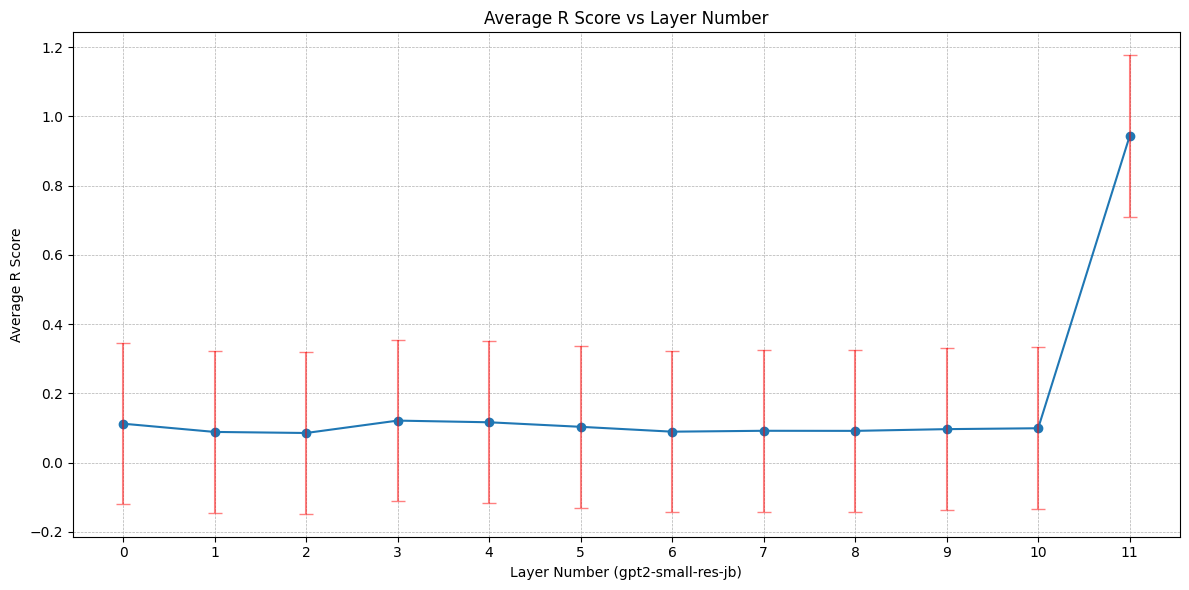

In [44]:

def generate_sentences(min_length=15, max_length=25, num_sentences=3):
    dataset = load_dataset('wikitext', 'wikitext-103-raw-v1', split='train', streaming=True)
    sentences = []
    
    for example in dataset:
        for sentence in example['text'].split('.'):
            sentence = sentence.strip()
            words = sentence.split()
            if min_length <= len(words) <= max_length:
                truncate_point = random.randint(1, len(words) - 1)  # Ensure at least one word remains
                truncated_sentence = ' '.join(words[:truncate_point])
                sentences.append(truncated_sentence)
                
                if len(sentences) >= num_sentences:
                    random.shuffle(sentences)
                    return sentences[:num_sentences]
    
    # If we couldn't find enough sentences, shuffle and return what we have
    random.shuffle(sentences)
    return sentences[:num_sentences]

def calculate_r_score_for_sentence(model, sae, sentence, target_layer, k=5, n_steps=30):
    input_ids = model.to_tokens(sentence, prepend_bos=True)
    print(input_ids.shape)
    r_score, a, b, c = compute_r_score(model, sae, input_ids, target_layer, k, n_steps)
    return r_score

def plot_r_score_vs_layer():
    model = HookedTransformer.from_pretrained("gpt2-small").to('cuda')
    num_layers = 12  # GPT-2 small has 12 layers
    sentences = generate_sentences(num_sentences=2)
    
    avg_r_scores = []
    
    for layer in tqdm(range(num_layers), desc="Processing layers"):
        sae, _, _ = SAE.from_pretrained(
            release="gpt2-small-res-jb",
            sae_id=f"blocks.{layer}.hook_resid_pre",
            device="cuda:0"
        )
        target_layer = f"blocks.{layer}.hook_resid_pre"
        
        layer_r_scores = []
        for sentence in sentences:
            r_score = calculate_r_score_for_sentence(model, sae, sentence, target_layer).mean().item()
            layer_r_scores.append(r_score)
        
        avg_r_score = np.mean(layer_r_scores)
        avg_r_scores.append(avg_r_score)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(num_layers), avg_r_scores, marker='o')
    plt.xlabel('Layer Number (gpt2-small-res-jb)')
    plt.ylabel('Average R Score')
    plt.title('Average R Score vs Layer Number')
    plt.xticks(range(num_layers))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Add error bars (standard deviation)
    plt.errorbar(range(num_layers), avg_r_scores, yerr=np.std(avg_r_scores), fmt='none', capsize=5, color='r', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Run the analysis and plot the results
plot_r_score_vs_layer()

## Average R vs Latent Space Size

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


Processing 768 features:  10%|█         | 1/10 [00:11<01:47, 11.94s/it]

r_scores tensor([0.2291, 0.0920, 0.0356, 0.1110, 0.1004, 0.1237, 0.1342, 0.1151, 0.1328,
        0.1733, 0.1786], device='cuda:0')


Processing 768 features:  20%|██        | 2/10 [00:23<01:33, 11.73s/it]

r_scores tensor([0.3861, 0.0635, 0.0774, 0.0332, 0.0719, 0.0556, 0.0815, 0.1087, 0.1097,
        0.0469, 0.0877, 0.3080], device='cuda:0')


Processing 768 features:  30%|███       | 3/10 [00:34<01:19, 11.31s/it]

r_scores tensor([0.0709, 0.0807, 0.1262, 0.0607, 0.0913, 0.0851, 0.0603, 0.0537, 0.0569],
       device='cuda:0')


Processing 768 features:  40%|████      | 4/10 [00:40<00:56,  9.39s/it]

r_scores tensor([0.2091, 0.0947, 0.0546, 0.0919, 0.0828, 0.0525, 0.0864, 0.0718, 0.0698,
        0.1026, 0.0736, 0.0915, 0.0894, 0.0698, 0.1400, 0.0372, 0.0887, 0.0656],
       device='cuda:0')


Processing 768 features:  50%|█████     | 5/10 [00:47<00:41,  8.26s/it]

r_scores tensor([0.4269, 0.1315, 0.1298, 0.1210, 0.0562, 0.0986, 0.0791, 0.1473, 0.0678,
        0.1049, 0.0802, 0.1276], device='cuda:0')


Processing 768 features:  60%|██████    | 6/10 [00:53<00:30,  7.57s/it]

r_scores tensor([0.1915, 0.0687, 0.0854, 0.0645, 0.0636, 0.0280, 0.1024],
       device='cuda:0')


Processing 768 features:  70%|███████   | 7/10 [00:59<00:21,  7.15s/it]

r_scores tensor([0.3791, 0.0820], device='cuda:0')


Processing 768 features:  80%|████████  | 8/10 [01:05<00:13,  6.87s/it]

r_scores tensor([0.1202, 0.0711, 0.0856, 0.0732, 0.0991, 0.1228, 0.0655, 0.1043, 0.0488,
        0.0566, 0.0642, 0.1218, 0.0582, 0.2203, 0.1302], device='cuda:0')


Processing 768 features:  90%|█████████ | 9/10 [01:12<00:06,  6.72s/it]

r_scores tensor([0.3629, 0.0402, 0.1241, 0.0933, 0.0491, 0.1505], device='cuda:0')


Processing 768 features: 100%|██████████| 10/10 [01:18<00:00,  7.86s/it]

r_scores tensor([0.5365, 0.0831, 0.0722, 0.0489, 0.0688, 0.0678, 0.0382, 0.1200, 0.0516,
        0.0629, 0.0783, 0.0870, 0.1839, 0.0598, 0.0785, 0.1260, 0.1075, 0.0987,
        0.0499, 0.0485, 0.0933], device='cuda:0')



Processing 1536 features:  10%|█         | 1/10 [00:06<00:58,  6.54s/it]

r_scores tensor([0.2059, 0.0785, 0.1198, 0.0211, 0.1085, 0.1515, 0.1490, 0.0758, 0.1093,
        0.1238, 0.1163], device='cuda:0')


Processing 1536 features:  20%|██        | 2/10 [00:13<00:52,  6.56s/it]

r_scores tensor([0.3834, 0.0581, 0.0532, 0.0692, 0.0619, 0.0548, 0.1044, 0.0419, 0.1075,
        0.0868, 0.0813, 0.1771], device='cuda:0')


Processing 1536 features:  30%|███       | 3/10 [00:25<01:04,  9.26s/it]

r_scores tensor([0.2807, 0.0965, 0.1022, 0.0703, 0.1274, 0.0572, 0.0818, 0.1706, 0.0666],
       device='cuda:0')


Processing 1536 features:  40%|████      | 4/10 [00:38<01:04, 10.75s/it]

r_scores tensor([0.1958, 0.0577, 0.0560, 0.0903, 0.0507, 0.0207, 0.0863, 0.0962, 0.1290,
        0.1282, 0.1122, 0.0672, 0.0585, 0.0743, 0.1335, 0.0763, 0.0861, 0.2354],
       device='cuda:0')


Processing 1536 features:  50%|█████     | 5/10 [00:51<00:56, 11.34s/it]

r_scores tensor([0.3248, 0.1101, 0.1141, 0.0725, 0.0531, 0.0655, 0.0401, 0.1276, 0.0635,
        0.1249, 0.0552, 0.1199], device='cuda:0')


Processing 1536 features:  60%|██████    | 6/10 [01:02<00:46, 11.56s/it]

r_scores tensor([0.1073, 0.0637, 0.0865, 0.0486, 0.1119, 0.2763, 0.1092],
       device='cuda:0')


Processing 1536 features:  70%|███████   | 7/10 [01:15<00:36, 12.01s/it]

r_scores tensor([0.4576, 0.1021], device='cuda:0')


Processing 1536 features:  80%|████████  | 8/10 [01:28<00:24, 12.33s/it]

r_scores tensor([0.3679, 0.0815, 0.1168, 0.0600, 0.1501, 0.1052, 0.0468, 0.0911, 0.0640,
        0.0890, 0.0752, 0.1048, 0.0483, 0.2476, 0.1586], device='cuda:0')


Processing 1536 features:  90%|█████████ | 9/10 [01:41<00:12, 12.52s/it]

r_scores tensor([0.2828, 0.0271, 0.0729, 0.1222, 0.1098, 0.0494], device='cuda:0')


Processing 1536 features: 100%|██████████| 10/10 [01:48<00:00, 10.89s/it]

r_scores tensor([0.2669, 0.0566, 0.0558, 0.0939, 0.0657, 0.0424, 0.1104, 0.1081, 0.0897,
        0.0756, 0.0914, 0.0876, 0.1533, 0.1025, 0.0575, 0.0891, 0.0572, 0.1128,
        0.3367, 0.0915, 0.0679], device='cuda:0')



Processing 3072 features:  10%|█         | 1/10 [00:06<00:59,  6.60s/it]

r_scores tensor([0.0759, 0.0796, 0.1151, 0.0365, 0.0666, 0.1007, 0.0714, 0.0991, 0.1000,
        0.0869, 0.1332], device='cuda:0')


Processing 3072 features:  20%|██        | 2/10 [00:13<00:52,  6.57s/it]

r_scores tensor([0.3769, 0.0768, 0.0451, 0.0262, 0.0754, 0.0795, 0.1001, 0.0690, 0.0673,
        0.1658, 0.0640, 0.2207], device='cuda:0')


Processing 3072 features:  30%|███       | 3/10 [00:19<00:46,  6.61s/it]

r_scores tensor([0.2425, 0.0827, 0.0688, 0.0553, 0.1241, 0.0520, 0.0886, 0.1320, 0.0874],
       device='cuda:0')


Processing 3072 features:  40%|████      | 4/10 [00:26<00:40,  6.78s/it]

r_scores tensor([0.1931, 0.0592, 0.0428, 0.0785, 0.0458, 0.0736, 0.0760, 0.0594, 0.0820,
        0.1283, 0.0837, 0.1005, 0.0348, 0.0832, 0.1837, 0.0480, 0.0725, 0.0797],
       device='cuda:0')


Processing 3072 features:  50%|█████     | 5/10 [00:33<00:33,  6.69s/it]

r_scores tensor([0.3465, 0.1039, 0.1031, 0.0442, 0.0782, 0.0374, 0.0782, 0.0747, 0.0983,
        0.0778, 0.0638, 0.0751], device='cuda:0')


Processing 3072 features:  60%|██████    | 6/10 [00:39<00:26,  6.60s/it]

r_scores tensor([0.1140, 0.1188, 0.1085, 0.0603, 0.0672, 0.2023, 0.0883],
       device='cuda:0')


Processing 3072 features:  70%|███████   | 7/10 [00:46<00:19,  6.53s/it]

r_scores tensor([0.3188, 0.1012], device='cuda:0')


Processing 3072 features:  80%|████████  | 8/10 [00:52<00:12,  6.49s/it]

r_scores tensor([0.2991, 0.0835, 0.0832, 0.0869, 0.1110, 0.0828, 0.0682, 0.0999, 0.1028,
        0.0673, 0.0862, 0.0689, 0.0459, 0.0603, 0.0746], device='cuda:0')


Processing 3072 features:  90%|█████████ | 9/10 [00:58<00:06,  6.44s/it]

r_scores tensor([0.3078, 0.0421, 0.0982, 0.1032, 0.0988, 0.1297], device='cuda:0')


Processing 3072 features: 100%|██████████| 10/10 [01:05<00:00,  6.55s/it]

r_scores tensor([0.3081, 0.0555, 0.1223, 0.1060, 0.0812, 0.0550, 0.1002, 0.1358, 0.1005,
        0.0724, 0.1000, 0.0575, 0.1549, 0.1448, 0.1205, 0.1184, 0.0987, 0.0591,
        0.2625, 0.0871, 0.0687], device='cuda:0')



Processing 6144 features:  10%|█         | 1/10 [00:06<00:58,  6.52s/it]

r_scores tensor([0.1336, 0.0876, 0.0768, 0.0320, 0.0726, 0.0714, 0.1000, 0.1172, 0.0853,
        0.0354, 0.1056], device='cuda:0')


Processing 6144 features:  20%|██        | 2/10 [00:12<00:51,  6.44s/it]

r_scores tensor([0.3586, 0.0736, 0.0403, 0.0325, 0.0687, 0.0476, 0.1046, 0.1099, 0.0825,
        0.1217, 0.0761, 0.1105], device='cuda:0')


Processing 6144 features:  30%|███       | 3/10 [00:19<00:44,  6.38s/it]

r_scores tensor([0.1274, 0.0861, 0.1126, 0.0491, 0.0860, 0.1036, 0.0687, 0.0789, 0.0660],
       device='cuda:0')


Processing 6144 features:  40%|████      | 4/10 [00:25<00:38,  6.39s/it]

r_scores tensor([0.0814, 0.1258, 0.0542, 0.0466, 0.0474, 0.0523, 0.0636, 0.0605, 0.0594,
        0.0987, 0.0895, 0.0834, 0.0864, 0.0837, 0.0765, 0.1020, 0.0799, 0.1141],
       device='cuda:0')


Processing 6144 features:  50%|█████     | 5/10 [00:32<00:32,  6.47s/it]

r_scores tensor([0.3598, 0.1221, 0.0778, 0.0491, 0.0640, 0.0240, 0.0451, 0.0917, 0.0562,
        0.1171, 0.0856, 0.0738], device='cuda:0')


Processing 6144 features:  60%|██████    | 6/10 [00:38<00:26,  6.50s/it]

r_scores tensor([0.1669, 0.1262, 0.0732, 0.0436, 0.1082, 0.2160, 0.1017],
       device='cuda:0')


Processing 6144 features:  70%|███████   | 7/10 [00:45<00:19,  6.47s/it]

r_scores tensor([0.4319, 0.1141], device='cuda:0')


Processing 6144 features:  80%|████████  | 8/10 [00:51<00:12,  6.48s/it]

r_scores tensor([0.1792, 0.1138, 0.0707, 0.0330, 0.1382, 0.1014, 0.0772, 0.0559, 0.0751,
        0.0698, 0.0651, 0.1247, 0.0772, 0.0500, 0.0786], device='cuda:0')


Processing 6144 features:  90%|█████████ | 9/10 [00:58<00:06,  6.45s/it]

r_scores tensor([0.2290, 0.0552, 0.0812, 0.1049, 0.0821, 0.1021], device='cuda:0')


Processing 6144 features: 100%|██████████| 10/10 [01:04<00:00,  6.47s/it]

r_scores tensor([0.4016, 0.0457, 0.1592, 0.0917, 0.0605, 0.0821, 0.0620, 0.1186, 0.0703,
        0.1026, 0.0956, 0.0547, 0.0637, 0.0513, 0.0669, 0.1378, 0.0758, 0.0890,
        0.1770, 0.0470, 0.1728], device='cuda:0')



Processing 12288 features:  10%|█         | 1/10 [00:06<01:01,  6.83s/it]

r_scores tensor([0.0991, 0.1195, 0.0631, 0.0342, 0.0936, 0.1153, 0.0986, 0.0643, 0.1258,
        0.0358, 0.0788], device='cuda:0')


Processing 12288 features:  20%|██        | 2/10 [00:13<00:52,  6.55s/it]

r_scores tensor([0.3539, 0.0479, 0.0354, 0.0551, 0.0585, 0.0814, 0.1050, 0.0846, 0.0713,
        0.0773, 0.0508, 0.1141], device='cuda:0')


Processing 12288 features:  30%|███       | 3/10 [00:19<00:45,  6.49s/it]

r_scores tensor([0.0762, 0.0699, 0.0466, 0.0374, 0.0517, 0.1068, 0.1200, 0.1201, 0.0982],
       device='cuda:0')


Processing 12288 features:  40%|████      | 4/10 [00:25<00:38,  6.45s/it]

r_scores tensor([0.1173, 0.0634, 0.0672, 0.0800, 0.1049, 0.0611, 0.0770, 0.0408, 0.0498,
        0.0728, 0.0502, 0.0564, 0.0919, 0.0759, 0.1662, 0.0839, 0.0277, 0.0867],
       device='cuda:0')


Processing 12288 features:  50%|█████     | 5/10 [00:32<00:32,  6.43s/it]

r_scores tensor([0.3613, 0.0772, 0.1215, 0.0841, 0.0603, 0.0306, 0.0687, 0.0973, 0.0793,
        0.1455, 0.0924, 0.0547], device='cuda:0')


Processing 12288 features:  60%|██████    | 6/10 [00:38<00:25,  6.39s/it]

r_scores tensor([0.1600, 0.0686, 0.0971, 0.0758, 0.0749, 0.1626, 0.1300],
       device='cuda:0')


Processing 12288 features:  70%|███████   | 7/10 [00:45<00:19,  6.36s/it]

r_scores tensor([0.3048, 0.0953], device='cuda:0')


Processing 12288 features:  80%|████████  | 8/10 [00:51<00:12,  6.36s/it]

r_scores tensor([0.1985, 0.1095, 0.1204, 0.0769, 0.1618, 0.1269, 0.0849, 0.1235, 0.0892,
        0.0684, 0.0661, 0.0368, 0.0665, 0.0805, 0.0451], device='cuda:0')


Processing 12288 features:  90%|█████████ | 9/10 [00:57<00:06,  6.36s/it]

r_scores tensor([0.2058, 0.0457, 0.1206, 0.0664, 0.1420, 0.0648], device='cuda:0')


Processing 12288 features: 100%|██████████| 10/10 [01:04<00:00,  6.42s/it]

r_scores tensor([0.3702, 0.0800, 0.1005, 0.0400, 0.0421, 0.0606, 0.0637, 0.1143, 0.0820,
        0.1221, 0.0733, 0.0683, 0.0882, 0.0505, 0.0496, 0.1397, 0.0624, 0.1099,
        0.2401, 0.0859, 0.0627], device='cuda:0')



Processing 24576 features:  10%|█         | 1/10 [00:06<00:57,  6.36s/it]

r_scores tensor([0.1245, 0.1037, 0.0845, 0.0352, 0.0708, 0.1052, 0.1400, 0.0584, 0.0907,
        0.0610, 0.0758], device='cuda:0')


Processing 24576 features:  20%|██        | 2/10 [00:12<00:50,  6.35s/it]

r_scores tensor([0.3348, 0.0875, 0.0344, 0.1285, 0.0438, 0.0742, 0.0944, 0.0715, 0.0570,
        0.0882, 0.0748, 0.1307], device='cuda:0')


Processing 24576 features:  30%|███       | 3/10 [00:19<00:44,  6.35s/it]

r_scores tensor([0.1172, 0.0510, 0.1027, 0.0754, 0.0985, 0.1311, 0.0852, 0.0723, 0.1148],
       device='cuda:0')


Processing 24576 features:  40%|████      | 4/10 [00:25<00:38,  6.36s/it]

r_scores tensor([0.1183, 0.0989, 0.0672, 0.0666, 0.0847, 0.0830, 0.0834, 0.0415, 0.0851,
        0.0939, 0.0582, 0.0554, 0.0520, 0.0772, 0.0623, 0.0480, 0.0942, 0.0712],
       device='cuda:0')


Processing 24576 features:  50%|█████     | 5/10 [00:31<00:31,  6.38s/it]

r_scores tensor([0.3634, 0.0961, 0.1099, 0.0622, 0.0649, 0.0610, 0.1127, 0.1045, 0.0944,
        0.0916, 0.0991, 0.0573], device='cuda:0')


Processing 24576 features:  60%|██████    | 6/10 [00:38<00:25,  6.35s/it]

r_scores tensor([0.1410, 0.0701, 0.1448, 0.0449, 0.0683, 0.1644, 0.1801],
       device='cuda:0')


Processing 24576 features:  70%|███████   | 7/10 [00:44<00:19,  6.34s/it]

r_scores tensor([0.2471, 0.0658], device='cuda:0')


Processing 24576 features:  80%|████████  | 8/10 [00:50<00:12,  6.33s/it]

r_scores tensor([0.1737, 0.1457, 0.0496, 0.0709, 0.1527, 0.0997, 0.0822, 0.0973, 0.1261,
        0.0520, 0.0343, 0.0597, 0.0538, 0.0486, 0.1732], device='cuda:0')


Processing 24576 features:  90%|█████████ | 9/10 [00:57<00:06,  6.32s/it]

r_scores tensor([0.2453, 0.0931, 0.0818, 0.0806, 0.1041, 0.0899], device='cuda:0')


Processing 24576 features: 100%|██████████| 10/10 [01:03<00:00,  6.35s/it]

r_scores tensor([0.3620, 0.0937, 0.1081, 0.0455, 0.0567, 0.0574, 0.0839, 0.1558, 0.0438,
        0.1063, 0.1372, 0.0730, 0.0495, 0.0869, 0.0878, 0.0902, 0.0796, 0.0801,
        0.1579, 0.0851, 0.1570], device='cuda:0')



Processing 49152 features:  10%|█         | 1/10 [00:06<00:57,  6.34s/it]

r_scores tensor([0.1697, 0.0797, 0.0551, 0.0958, 0.0575, 0.1073, 0.0927, 0.0667, 0.0795,
        0.0560, 0.0797], device='cuda:0')


Processing 49152 features:  20%|██        | 2/10 [00:12<00:50,  6.34s/it]

r_scores tensor([0.3411, 0.0493, 0.0286, 0.0555, 0.0412, 0.0656, 0.0761, 0.1019, 0.0470,
        0.0634, 0.0441, 0.1133], device='cuda:0')


Processing 49152 features:  30%|███       | 3/10 [00:19<00:44,  6.34s/it]

r_scores tensor([0.0877, 0.0458, 0.1235, 0.0544, 0.0879, 0.0819, 0.0716, 0.1124, 0.0987],
       device='cuda:0')


Processing 49152 features:  40%|████      | 4/10 [00:25<00:38,  6.35s/it]

r_scores tensor([0.1163, 0.0940, 0.1146, 0.0764, 0.0929, 0.0904, 0.0332, 0.0527, 0.0911,
        0.0752, 0.1062, 0.0662, 0.0619, 0.0819, 0.0741, 0.0545, 0.0622, 0.1527],
       device='cuda:0')


Processing 49152 features:  50%|█████     | 5/10 [00:31<00:31,  6.37s/it]

r_scores tensor([0.3686, 0.1264, 0.0799, 0.0663, 0.0990, 0.1177, 0.0966, 0.1024, 0.1021,
        0.0779, 0.0857, 0.0564], device='cuda:0')


Processing 49152 features:  60%|██████    | 6/10 [00:38<00:25,  6.33s/it]

r_scores tensor([0.1299, 0.0758, 0.0988, 0.0837, 0.0900, 0.0896, 0.1930],
       device='cuda:0')


Processing 49152 features:  70%|███████   | 7/10 [00:44<00:18,  6.31s/it]

r_scores tensor([0.2640, 0.0977], device='cuda:0')


Processing 49152 features:  80%|████████  | 8/10 [00:50<00:12,  6.32s/it]

r_scores tensor([0.2049, 0.0997, 0.0781, 0.0474, 0.0718, 0.1075, 0.0717, 0.0515, 0.1103,
        0.0600, 0.0728, 0.0703, 0.0373, 0.1228, 0.0851], device='cuda:0')


Processing 49152 features:  90%|█████████ | 9/10 [00:56<00:06,  6.32s/it]

r_scores tensor([0.1915, 0.0762, 0.0751, 0.0792, 0.0626, 0.1283], device='cuda:0')


Processing 49152 features: 100%|██████████| 10/10 [01:03<00:00,  6.34s/it]

r_scores tensor([0.3714, 0.0770, 0.0832, 0.0986, 0.0615, 0.0739, 0.0739, 0.1702, 0.0537,
        0.0689, 0.0541, 0.0569, 0.0561, 0.1050, 0.1237, 0.0826, 0.1066, 0.0829,
        0.0965, 0.0487, 0.1013], device='cuda:0')



Processing 98304 features:  10%|█         | 1/10 [00:06<00:57,  6.39s/it]

r_scores tensor([0.0543, 0.1380, 0.0746, 0.0690, 0.0563, 0.0592, 0.0995, 0.0749, 0.0543,
        0.0964, 0.0501], device='cuda:0')


Processing 98304 features:  20%|██        | 2/10 [00:12<00:50,  6.37s/it]

r_scores tensor([0.3601, 0.0337, 0.0582, 0.0325, 0.0818, 0.0569, 0.1039, 0.0829, 0.0583,
        0.0283, 0.1000, 0.1565], device='cuda:0')


Processing 98304 features:  30%|███       | 3/10 [00:19<00:45,  6.46s/it]

r_scores tensor([0.0726, 0.0892, 0.1058, 0.0880, 0.0480, 0.0924, 0.0568, 0.1628, 0.0834],
       device='cuda:0')


Processing 98304 features:  40%|████      | 4/10 [00:25<00:39,  6.52s/it]

r_scores tensor([0.0820, 0.1177, 0.0668, 0.0723, 0.0833, 0.1005, 0.0487, 0.1029, 0.1361,
        0.1318, 0.0633, 0.0521, 0.1185, 0.1034, 0.1051, 0.0751, 0.1892, 0.1534],
       device='cuda:0')


Processing 98304 features:  50%|█████     | 5/10 [00:32<00:32,  6.48s/it]

r_scores tensor([0.3671, 0.1517, 0.1093, 0.0690, 0.0993, 0.1072, 0.1081, 0.0871, 0.0865,
        0.0792, 0.1260, 0.1231], device='cuda:0')


Processing 98304 features:  60%|██████    | 6/10 [00:38<00:25,  6.46s/it]

r_scores tensor([0.1333, 0.0740, 0.0785, 0.0559, 0.0514, 0.1449, 0.1766],
       device='cuda:0')


Processing 98304 features:  70%|███████   | 7/10 [00:45<00:19,  6.42s/it]

r_scores tensor([0.2067, 0.0961], device='cuda:0')


Processing 98304 features:  80%|████████  | 8/10 [00:51<00:12,  6.44s/it]

r_scores tensor([0.2065, 0.1070, 0.0844, 0.0630, 0.1013, 0.0960, 0.0561, 0.0526, 0.1168,
        0.0589, 0.0769, 0.0270, 0.0824, 0.0516, 0.0839], device='cuda:0')


Processing 98304 features:  90%|█████████ | 9/10 [00:58<00:06,  6.47s/it]

r_scores tensor([0.1975, 0.1164, 0.1860, 0.0614, 0.0973, 0.1735], device='cuda:0')


Processing 98304 features: 100%|██████████| 10/10 [01:04<00:00,  6.46s/it]

r_scores tensor([0.3955, 0.0763, 0.0555, 0.0502, 0.0907, 0.0200, 0.0646, 0.1101, 0.0656,
        0.1028, 0.1019, 0.0760, 0.1777, 0.0622, 0.0925, 0.0641, 0.0857, 0.0474,
        0.1448, 0.0860, 0.1176], device='cuda:0')


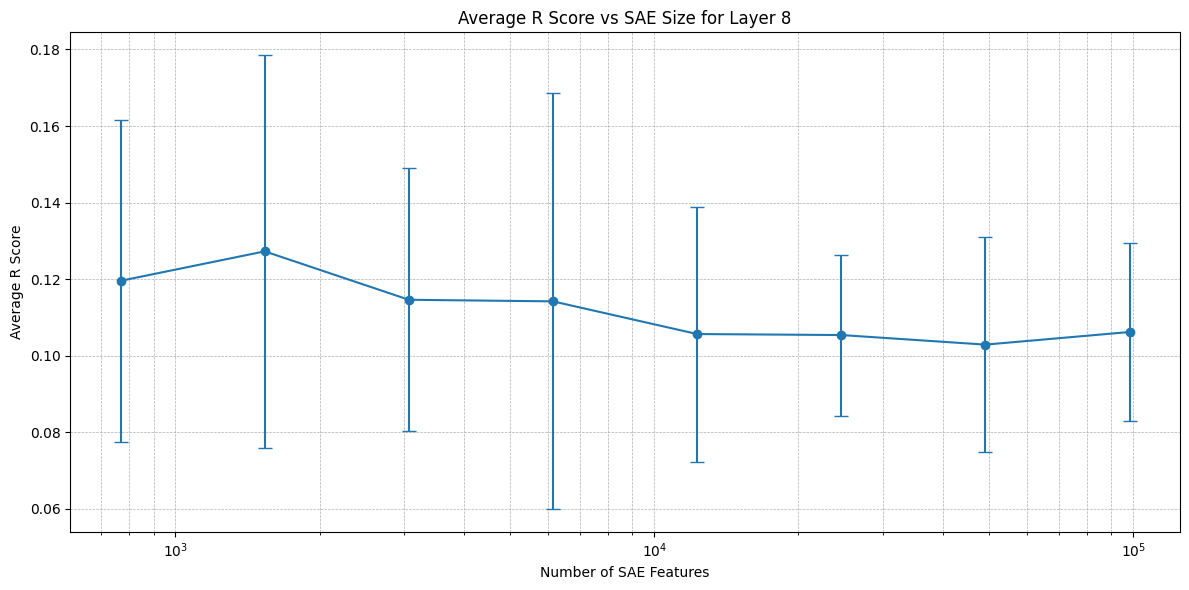


Results:
SAE Size: 768, Avg R Score: 0.1196 ± 0.0421
SAE Size: 1536, Avg R Score: 0.1273 ± 0.0513
SAE Size: 3072, Avg R Score: 0.1146 ± 0.0343
SAE Size: 6144, Avg R Score: 0.1142 ± 0.0543
SAE Size: 12288, Avg R Score: 0.1057 ± 0.0333
SAE Size: 24576, Avg R Score: 0.1054 ± 0.0210
SAE Size: 49152, Avg R Score: 0.1029 ± 0.0281
SAE Size: 98304, Avg R Score: 0.1062 ± 0.0233


In [47]:
import gc

# SAE configurations for layer 8
SAE_CONFIGS = [
    ("gpt2-small-res-jb-feature-splitting", 768),
    ("gpt2-small-res-jb-feature-splitting", 1536),
    ("gpt2-small-res-jb-feature-splitting", 3072),
    ("gpt2-small-res-jb-feature-splitting", 6144),
    ("gpt2-small-res-jb-feature-splitting", 12288),
    ("gpt2-small-res-jb-feature-splitting", 24576),
    ("gpt2-small-res-jb-feature-splitting", 49152),
    ("gpt2-small-res-jb-feature-splitting", 98304)
]


def generate_sentences(min_length=15, max_length=25, num_sentences=50):
    dataset = load_dataset('wikitext', 'wikitext-103-raw-v1', split='train', streaming=True)
    sentences = []
    
    for example in dataset:
        for sentence in example['text'].split('.'):
            sentence = sentence.strip()
            words = sentence.split()
            if min_length <= len(words) <= max_length:
                truncate_point = random.randint(1, len(words) - 1)  # Ensure at least one word remains
                truncated_sentence = ' '.join(words[:truncate_point])
                sentences.append(truncated_sentence)
                
                if len(sentences) >= num_sentences:
                    random.shuffle(sentences)
                    return sentences[:num_sentences]
    
    # If we couldn't find enough sentences, shuffle and return what we have
    random.shuffle(sentences)
    return sentences[:num_sentences]

def calculate_r_score_for_sentence(model, sae, sentence, target_layer, k=5, n_steps=30):
    input_ids = model.to_tokens(sentence, prepend_bos=True)
    r_score, _, _,_ = compute_r_score(model, sae, input_ids, target_layer, k, n_steps)
    return r_score

def compute_average_r_score(model, sae_config, sentences):
    sae_name, num_features = sae_config
    target_layer = f"blocks.8.hook_resid_pre_{num_features}"

    sae, _, _ = SAE.from_pretrained(
        release=sae_name,
        sae_id=target_layer,
        device="cuda:0"
    )

    r_scores = []
    for sentence in tqdm(sentences, desc=f"Processing {num_features} features"):
        r_score = calculate_r_score_for_sentence(model, sae, sentence, "blocks.8.hook_resid_pre").mean().item()
        r_scores.append(r_score)

    avg_r_score = np.mean(r_scores)
    std_r_score = np.std(r_scores)

    # Clear CUDA cache and delete SAE to free up memory
    del sae
    torch.cuda.empty_cache()
    gc.collect()

    return avg_r_score, std_r_score

def plot_r_scores(r_scores, r_score_stds):
    plt.figure(figsize=(12, 6))
    feature_sizes = [config[1] for config in SAE_CONFIGS]
    
    plt.errorbar(feature_sizes, r_scores, yerr=r_score_stds, fmt='o-', capsize=5)
    plt.xscale('log')
    plt.xlabel('Number of SAE Features')
    plt.ylabel('Average R Score')
    plt.title('Average R Score vs SAE Size for Layer 8')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('r_scores_vs_sae_size_layer8.png', dpi=300)
    plt.show()

def main():
    model = HookedTransformer.from_pretrained("gpt2-small").to('cuda')

    sentences = generate_sentences(num_sentences=10)  
    r_scores = []
    r_score_stds = []

    for sae_config in SAE_CONFIGS:
        avg_r_score, std_r_score = compute_average_r_score(model, sae_config, sentences)
        r_scores.append(avg_r_score)
        r_score_stds.append(std_r_score)

    plot_r_scores(r_scores, r_score_stds)

    # Print results
    print("\nResults:")
    for (_, num_features), avg_score, std_score in zip(SAE_CONFIGS, r_scores, r_score_stds):
        print(f"SAE Size: {num_features}, Avg R Score: {avg_score:.4f} ± {std_score:.4f}")

if __name__ == "__main__":
    main()